In [ ]:
!pip install topicnet
!pip install bigartm
!pip install pymorphy2

In [2]:
import artm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style="darkgrid", palette="Set2")

from topicnet.dataset_manager import api

# topicnet imports
from topicnet.cooking_machine.cubes import (
    CubeCreator,
    GreedyStrategy,
    PerplexityStrategy,
    RegularizationControllerCube,
    RegularizersModifierCube,
)
from topicnet.cooking_machine.dataset import Dataset
from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.models import BaseScore
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.model_constructor import add_standard_scores
from topicnet.cooking_machine.model_constructor import init_simple_default_model
from topicnet.cooking_machine.pretty_output import make_notebook_pretty
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from topicnet.viewers.top_tokens_viewer import TopTokensViewer

from IPython.display import display, display_html

# for preprocessing
import nltk

from nltk.collocations import (
    BigramAssocMeasures,
    BigramCollocationFinder,
)
from nltk.corpus import (
    stopwords,
    wordnet,
)

nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger_ru")
nltk.download("stopwords")

from nltk.stem import WordNetLemmatizer

from pymorphy2 import MorphAnalyzer

from collections import Counter

from tqdm import tqdm

from topicnet.cooking_machine.model_constructor import (
    create_default_topics,
    count_vocab_size,
    init_model,
)

from topicnet.cooking_machine.rel_toolbox_lite import (
    count_vocab_size,
    modality_weight_rel2abs,
)

from typing import Dict, List

from time import process_time

/opt/conda/lib/python3.7/site-packages/nltk/decorators.py:70: DeprecationWarning:

`formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly



[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Загружаем [данные](https://disk.yandex.ru/d/DAdhmVB2eFkdBQ) с мая по август 2008 года.

In [3]:
# %cp /kaggle/input/lenta-mid-2008/lenta_2008_may_aug_preprocessed.csv .
lenta_data = Dataset("/kaggle/working/lenta_2008_may_aug_preprocessed.csv")

/opt/conda/lib/python3.7/site-packages/topicnet/cooking_machine/dataset.py:220: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version.





Необходимо регулировать случайность, поэтому заведём возможность обновлять сид.

In [5]:
def init_simple_default_model_with_seed(
    dataset: Dataset,
    modalities_to_use: List[str] or Dict[str, float],
    main_modality: str,
    specific_topics: List[str] or int,
    background_topics: List[str] or int,
    seed: int = -1,
) -> artm.ARTM:
    if isinstance(modalities_to_use, dict):
        modalities_weights = modalities_to_use
    else:
        modalities_weights = {class_id: 1 for class_id in modalities_to_use}

    specific_topic_names, background_topic_names = create_default_topics(
        specific_topics, background_topics
    )
    dictionary = dataset.get_dictionary()

    tokens_data = count_vocab_size(dictionary, modalities_to_use)
    abs_weights = modality_weight_rel2abs(
        tokens_data, modalities_weights, main_modality
    )

    model = init_model(
        topic_names=specific_topic_names + background_topic_names,
        class_ids=abs_weights,
    )

    if len(background_topic_names) > 0:
        model.regularizers.add(
            artm.SmoothSparsePhiRegularizer(
                name="smooth_phi_bcg",
                topic_names=background_topic_names,
                tau=0.0,
                class_ids=[main_modality],
            ),
        )
        model.regularizers.add(
            artm.SmoothSparseThetaRegularizer(
                name="smooth_theta_bcg",
                topic_names=background_topic_names,
                tau=0.0,
            ),
        )

    model.seed = seed
    model.initialize(dictionary)
    add_standard_scores(
        model, main_modality=main_modality, all_modalities=modalities_to_use
    )

    return model

In [131]:
TOTAL_TOPICS = 100

model_0 = init_simple_default_model_with_seed(
    dataset=lenta_data,
    modalities_to_use={"@lemmatized": 1.2, "@bigram": 1.0},
    main_modality="@bigram",
    specific_topics=TOTAL_TOPICS,
    background_topics=1,
    seed=64,
)

tm_0 = TopicModel(model_0)

Обучаем простую базовую модель на $25$ итераций.

In [132]:
ITER_NUM = 25

for _ in tqdm(range(ITER_NUM)):
    tm_0._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

100%|██████████| 25/25 [03:03<00:00,  7.33s/it]


Смотрим, как представлены темы.

In [133]:
model_0_top_tok = TopTokensViewer(tm_0, num_top_tokens=5, method="phi")
model_0_top_tok.view_from_jupyter()

topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 лига_чемпион 
 0.152270 
 
 
 кубок_уефа 
 0.088650 
 
 
 квалификационный_раунд 
 0.045500 
 
 
 чрезвычайный_ситуация 
 0.040260 
 
 
 финальный_матч 
 0.037760 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 матч 
 0.020460 
 
 
 чемпион 
 0.018300 
 
 
 лига 
 0.017730 
 
 
 уефа 
 0.016180 
 
 
 болельщик 
 0.013170 
 
 
 
 
 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 нью_йорк 
 0.278020 
 
 
 сомалийский_пират 
 0.033780 
 
 
 домодедовский_авиалиния 
 0.029240 
 
 
 аденский_залив 
 0.024790 
 
 
 аэропорт_домодедово 
 0.024160 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 нью 
 0.033260 
 
 
 йорк 
 0.027090 
 
 
 который 
 0.012360 
 
 
 год 
 0.011320 
 
 
 авиакомпания 
 0.011220 
 
 
 
 
 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 министерство_оборона 
 0.111600 
 
 
 непризнанный_республика 
 0.090440 
 
 
 кодорский_ущелие 
 0.053560 
 
 
 грузино_абхазский 
 0.038870 
 
 
 силовой_структура 
 0.035770 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 грузия 
 0.034400 
 
 
 грузинский 
 0.031970 
 
 
 абхазия 
 0.024760 
 
 
 российский 
 0.022070 
 
 
 военный 
 0.016760 
 
 
 
 
 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 уго_чавес 
 0.081480 
 
 
 тёмный_материя 
 0.048890 
 
 
 латинский_америка 
 0.044360 
 
 
 венесуэла_уго 
 0.035310 
 
 
 вне_зависимость 
 0.024910 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 звезда 
 0.015380 
 
 
 венесуэла 
 0.012410 
 
 
 галактика 
 0.011610 
 
 
 год 
 0.010950 
 
 
 чавес 
 0.010340 
 
 
 
 
 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 взрывной_устройство 
 0.179600 
 
 
 рао_еэс 
 0.104820 
 
 
 взрывчатый_вещество 
 0.033990 
 
 
 анатолий_чубайс 
 0.031380 
 
 
 самодельный_взрывной 
 0.029780 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 взрыв 
 0.046140 
 
 
 устройство 
 0.021270 
 
 
 взрывной 
 0.017390 
 
 
 бомба 
 0.011700 
 
 
 рао 
 0.010940 
 
 
 
 
 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 добыча_нефть 
 0.096500 
 
 
 уплата_налог 
 0.059940 
 
 
 досрочный_освобождение 
 0.050170 
 
 
 михаил_ходорковский 
 0.050170 
 
 
 уклонение_уплата 
 0.044390 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.029850 
 
 
 ходорковский 
 0.016280 
 
 
 нефть 
 0.012780 
 
 
 лебедев 
 0.011180 
 
 
 который 
 0.010530 
 
 
 
 
 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 штаб_квартира 
 0.082440 
 
 
 кабинет_министр 
 0.078080 
 
 
 советский_союз 
 0.044540 
 
 
 отечественный_война 
 0.037400 
 
 
 великий_отечественный 
 0.034850 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 ирак 
 0.031460 
 
 
 год 
 0.015230 
 
 
 который 
 0.011970 
 
 
 страна 
 0.011780 
 
 
 иракский 
 0.010220 
 
 
 
 
 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 лиссабонский_договор 
 0.086820 
 
 
 северный_поток 
 0.031010 
 
 
 елизавета_ii 
 0.029630 
 
 
 call_of 
 0.028940 
 
 
 of_duty 
 0.028940 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.014940 
 
 
 договор 
 0.014830 
 
 
 который 
 0.014440 
 
 
 ес 
 0.012030 
 
 
 страна 
 0.010900 
 
 
 
 
 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 барак_обама 
 0.151680 
 
 
 демократический_партия 
 0.150660 
 
 
 хиллари_клинтон 
 0.093180 
 
 
 предвыборный_гонка 
 0.023540 
 
 
 северный_каролина 
 0.022740 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 обама 
 0.038170 
 
 
 клинтон 
 0.021060 
 
 
 партия 
 0.019140 
 
 
 демократический 
 0.018650 
 
 
 кандидат 
 0.018260 
 
 
 
 
 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 


Релевантные: 91

Нерелевантные: -

Все остальные являются мусорными.

Далее нам необходима работа со словарём, чтобы использовать регуляризатор сглаживания для фиксации тем.

In [9]:
def _get_dict_line_for_topic(
    dict_line: str,
    topic_col,
) -> str:
    dict_items = dict_line.split(", ")
    token, modality = dict_items[:2]
    dict_items[2] = str(topic_col[modality][token])

    return ", ".join(dict_items)

Запоминаем словарь.

In [10]:
lenta_data.get_dictionary().save_text("dict.txt")
dict_lines = open("dict.txt").readlines()

Пишем словарь для релевантных тем.

In [72]:
relevant_0 = ["topic_91"]

for topic_name in relevant_0:
    topic_col = tm_0.get_phi().loc[:, topic_name]
    topic_dict_lines = dict_lines[:2]

    for l in tqdm(dict_lines[2:], total=len(dict_lines[2:])):
        topic_dict_lines.append(_get_dict_line_for_topic(l, topic_col))

    with open(f"dict_{topic_name}.txt", "w") as f:
        f.writelines(topic_dict_lines)

100%|██████████| 79491/79491 [29:51<00:00, 44.37it/s]


Клонируем тему.

In [134]:
tm_1 = TopicModel.clone(tm_0)

Для фиксации потребуется довольно большой коэффициент, например, ${10}^{10}$

In [27]:
TAU_PRESERVE = 10**10  # используем большой коэффициент для сохранения релевантных тем

Заводим регуляризатор сглаживания.

In [135]:
dictionaries = []

for topic_name in relevant_0:
    dictionary = artm.Dictionary()
    dictionary.load_text(f"dict_{topic_name}.txt")
    dictionaries.append(dictionary)

    tm_1._model.regularizers.add(
        artm.regularizers.SmoothSparsePhiRegularizer(
            name=f"preserve_relevant_{topic_name}",
            tau=TAU_PRESERVE,
            class_ids=["@bigram", "@lemmatized"],
            topic_names=[topic_name],
            dictionary=dictionary,
        )
    )

In [136]:
garbage_topics_0 = []
for i in tqdm(range(TOTAL_TOPICS)):
    topic_name = f"topic_{i}"
    if topic_name not in relevant_0:
        garbage_topics_0.append(topic_name)

# пока используем обычный регуляризатор для определённых тем, нужно будет заменить на собственный
tm_1._model.regularizers.add(
    artm.regularizers.DecorrelatorPhiRegularizer(
        name="decorrelate_garbage_topics",
        tau=10000,
        class_ids=["@bigram", "@lemmatized"],
        topic_names=garbage_topics_0,
    )
)

tm_1._model.regularizers.add(
    artm.regularizers.ImproveCoherencePhiRegularizer(
        name="improve_coherence_garbage",
        tau=20000,
        class_ids=["@bigram", "@lemmatized"],
        topic_names=garbage_topics_0,
    )
)

tm_1._model.regularizers.add(
    artm.regularizers.BitermsPhiRegularizer(
        name="biterms_garbage",
        tau=20000,
        class_ids=["@bigram", "@lemmatized"],
        topic_names=garbage_topics_0,
    )
)

100%|██████████| 100/100 [00:00<00:00, 171476.04it/s]


In [137]:
for _ in tqdm(range(ITER_NUM)):
    tm_1._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

100%|██████████| 25/25 [03:17<00:00,  7.89s/it]


In [138]:
model_1_top_tok = TopTokensViewer(tm_1, num_top_tokens=5, method="phi")
model_1_top_tok.view_from_jupyter()

topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 лига_чемпион 
 0.168310 
 
 
 кубок_уефа 
 0.092030 
 
 
 квалификационный_раунд 
 0.043050 
 
 
 чрезвычайный_ситуация 
 0.040970 
 
 
 финальный_матч 
 0.037420 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 лига 
 0.025180 
 
 
 чемпион 
 0.023050 
 
 
 уефа 
 0.021760 
 
 
 матч 
 0.017880 
 
 
 болельщик 
 0.017700 
 
 
 
 
 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 нью_йорк 
 0.303210 
 
 
 сомалийский_пират 
 0.031580 
 
 
 домодедовский_авиалиния 
 0.028820 
 
 
 аденский_залив 
 0.024430 
 
 
 аэропорт_домодедово 
 0.023810 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 нью 
 0.050270 
 
 
 йорк 
 0.041300 
 
 
 пират 
 0.012960 
 
 
 airunion 
 0.012450 
 
 
 захватить 
 0.010400 
 
 
 
 
 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 министерство_оборона 
 0.121050 
 
 
 непризнанный_республика 
 0.061870 
 
 
 кодорский_ущелие 
 0.056430 
 
 
 грузино_абхазский 
 0.040950 
 
 
 силовой_структура 
 0.039280 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 грузинский 
 0.033250 
 
 
 грузия 
 0.032090 
 
 
 абхазия 
 0.030500 
 
 
 министерство 
 0.016260 
 
 
 войско 
 0.014950 
 
 
 
 
 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 уго_чавес 
 0.082150 
 
 
 тёмный_материя 
 0.049290 
 
 
 латинский_америка 
 0.044730 
 
 
 венесуэла_уго 
 0.035600 
 
 
 last_fm 
 0.024650 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 звезда 
 0.018160 
 
 
 венесуэла 
 0.015330 
 
 
 галактика 
 0.014440 
 
 
 чавес 
 0.012740 
 
 
 астроном 
 0.011600 
 
 
 
 
 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 взрывной_устройство 
 0.181630 
 
 
 рао_еэс 
 0.106010 
 
 
 взрывчатый_вещество 
 0.036460 
 
 
 анатолий_чубайс 
 0.031730 
 
 
 самодельный_взрывной 
 0.031130 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 взрыв 
 0.078700 
 
 
 устройство 
 0.027390 
 
 
 взрывной 
 0.023000 
 
 
 бомба 
 0.017200 
 
 
 рао 
 0.014450 
 
 
 
 
 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 добыча_нефть 
 0.102110 
 
 
 уплата_налог 
 0.063070 
 
 
 досрочный_освобождение 
 0.052560 
 
 
 михаил_ходорковский 
 0.052560 
 
 
 уклонение_уплата 
 0.046550 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 ходорковский 
 0.023870 
 
 
 лебедев 
 0.016220 
 
 
 налог 
 0.015080 
 
 
 добыча 
 0.014360 
 
 
 юкос 
 0.010390 
 
 
 
 
 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 кабинет_министр 
 0.081900 
 
 
 штаб_квартира 
 0.080560 
 
 
 советский_союз 
 0.045680 
 
 
 отечественный_война 
 0.036540 
 
 
 великий_отечественный 
 0.034050 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 ирак 
 0.041010 
 
 
 эстония 
 0.014800 
 
 
 иракский 
 0.013770 
 
 
 вто 
 0.011550 
 
 
 кабинет 
 0.009190 
 
 
 
 
 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 лиссабонский_договор 
 0.090470 
 
 
 северный_поток 
 0.032310 
 
 
 елизавета_ii 
 0.030870 
 
 
 call_of 
 0.030160 
 
 
 of_duty 
 0.030160 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 заложник 
 0.017760 
 
 
 ес 
 0.016780 
 
 
 договор 
 0.016500 
 
 
 евросоюз 
 0.012740 
 
 
 лиссабонский 
 0.012260 
 
 
 
 
 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 барак_обама 
 0.239500 
 
 
 демократический_партия 
 0.154060 
 
 
 хиллари_клинтон 
 0.084500 
 
 
 предвыборный_гонка 
 0.021440 
 
 
 северный_каролина 
 0.020300 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 обама 
 0.066660 
 
 
 кандидат 
 0.032840 
 
 
 барак 
 0.028570 
 
 
 клинтон 
 0.022870 
 
 
 демократический 
 0.021640 
 
 
 
 
 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
  

Посмотрим, улучшилась ли модель вообще по некоторым признакам. Обучим ещё на $25$ итераций базовую модель.

In [139]:
for _ in tqdm(range(ITER_NUM)):
    tm_0._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

100%|██████████| 25/25 [03:07<00:00,  7.49s/it]


Далее рисуем графики.

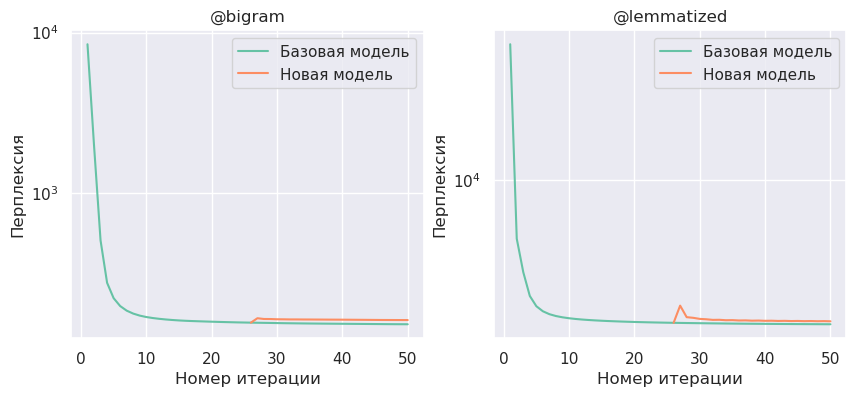

In [161]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("@bigram")
    plt.plot(
        np.arange(1, 51),
        tm_0.score_tracker["PerplexityScore@bigram"].value,
        label="Базовая модель",
    )
    plt.plot(
        np.arange(26, 51),
        tm_1.score_tracker["PerplexityScore@bigram"].value[25:],
        label="Новая модель",
    )
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Номер итерации")
    plt.ylabel("Перплексия")

    plt.subplot(1, 2, 2)
    plt.title("@lemmatized")
    plt.plot(
        np.arange(1, 51),
        tm_0.score_tracker["PerplexityScore@lemmatized"].value,
        label="Базовая модель",
    )
    plt.plot(
        np.arange(26, 51),
        tm_1.score_tracker["PerplexityScore@lemmatized"].value[25:],
        label="Новая модель",
    )
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Номер итерации")
    plt.ylabel("Перплексия")

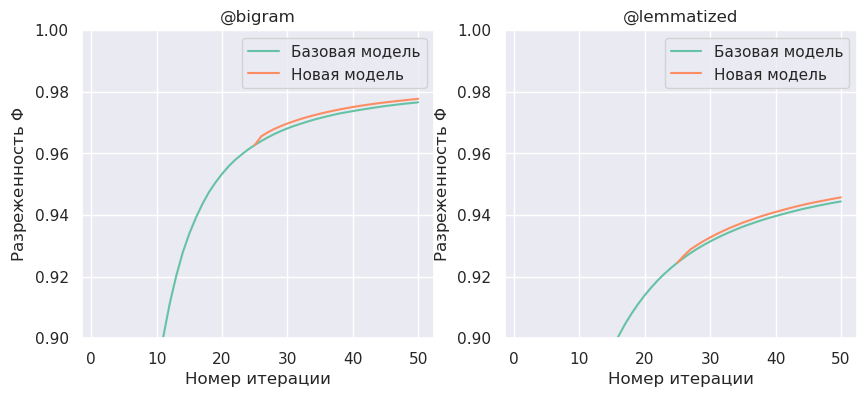

In [162]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("@bigram")
    plt.plot(
        np.arange(1, 51),
        tm_0.score_tracker["SparsityPhiScore@bigram"].value,
        label="Базовая модель",
    )
    plt.plot(
        np.arange(25, 51),
        tm_1.score_tracker["SparsityPhiScore@bigram"].value[24:],
        label="Новая модель",
    )
    plt.legend()
    plt.ylim(0.9, 1.0)
    plt.xlabel("Номер итерации")
    plt.ylabel("Разреженность $\\Phi$")

    plt.subplot(1, 2, 2)
    plt.title("@lemmatized")
    plt.plot(
        np.arange(1, 51),
        tm_0.score_tracker["SparsityPhiScore@lemmatized"].value,
        label="Базовая модель",
    )
    plt.plot(
        np.arange(25, 51),
        tm_1.score_tracker["SparsityPhiScore@lemmatized"].value[24:],
        label="Новая модель",
    )
    plt.legend()
    plt.ylim(0.9, 1.0)
    plt.xlabel("Номер итерации")
    plt.ylabel("Разреженность $\\Phi$")

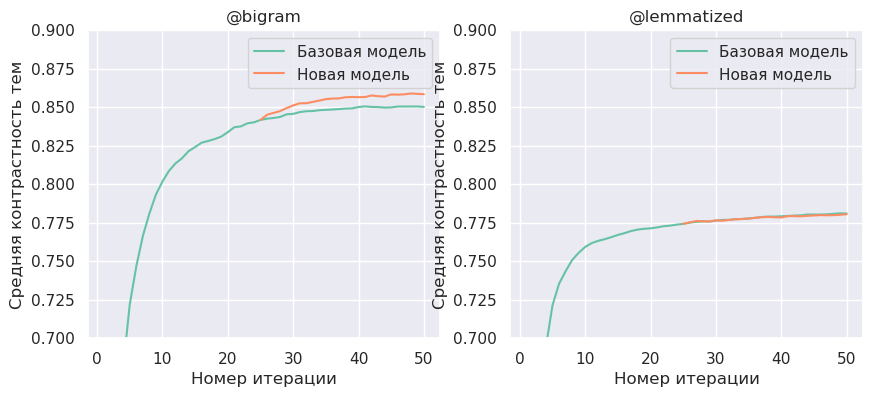

In [164]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("@bigram")
    plt.plot(
        np.arange(1, 51),
        tm_0.score_tracker["TopicKernel@bigram"].average_contrast,
        label="Базовая модель",
    )
    plt.plot(
        np.arange(25, 51),
        tm_1.score_tracker["TopicKernel@bigram"].average_contrast[24:],
        label="Новая модель",
    )
    plt.legend()
    plt.ylim(0.7, 0.9)
    plt.xlabel("Номер итерации")
    plt.ylabel("Средняя контрастность тем")

    plt.subplot(1, 2, 2)
    plt.title("@lemmatized")
    plt.plot(
        np.arange(1, 51),
        tm_0.score_tracker["TopicKernel@lemmatized"].average_contrast,
        label="Базовая модель",
    )
    plt.plot(
        np.arange(25, 51),
        tm_1.score_tracker["TopicKernel@lemmatized"].average_contrast[24:],
        label="Новая модель",
    )
    plt.legend()
    plt.ylim(0.7, 0.9)
    plt.xlabel("Номер итерации")
    plt.ylabel("Средняя контрастность тем")